In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

### Load data

In [2]:
df = pd.read_csv('transaction.csv')

# Drop the specified columns with 0 non-null values in place
columns_to_drop = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']

df.drop(columns=columns_to_drop, inplace=True)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


### Convert to Date Time object

In [3]:
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'])
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])

In [4]:
columns_to_drop = ['accountNumber', 'customerId','merchantName','cardCVV', 'enteredCVV', 'cardLast4Digits']
# Drop the specified columns with 0 non-null values in place
df.drop(columns=columns_to_drop, inplace=True)

### One hot encoding to convert categorical features

In [5]:
# Use pd.get_dummies() to create one-hot encoding for 'transactionType'
transaction_type_encoded = pd.get_dummies(df['transactionType'], prefix='transactionType_')

# Use pd.get_dummies() to create one-hot encoding for 'merchantCountryCode'
merchant_country_encoded = pd.get_dummies(df['merchantCountryCode'], prefix='merchantCountryCode_')

aqc_country_encoded = pd.get_dummies(df['acqCountry'], prefix='acqCountryCode_')

posEntryMode_encoded = pd.get_dummies(df['posEntryMode'], prefix='posEntryMode_')

posConditionCode_encoded = pd.get_dummies(df['posConditionCode'], prefix='posConditionCode_')

merchantCategoryCode_encoded = pd.get_dummies(df['merchantCategoryCode'], prefix='merchantCategoryCode_')

cardPresent_encoded = pd.get_dummies(df['cardPresent'], prefix='cardPresent_')

expirationDateKeyInMatch_encoded = pd.get_dummies(df['expirationDateKeyInMatch'], prefix='expirationDateKeyInMatch_')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
df_clean = df
df_clean = pd.concat([df, transaction_type_encoded, merchant_country_encoded, aqc_country_encoded, posEntryMode_encoded, 
                posConditionCode_encoded, merchantCategoryCode_encoded, cardPresent_encoded, 
                expirationDateKeyInMatch_encoded], axis=1)

In [6]:
df_clean.drop(['transactionType', 'merchantCountryCode'], axis=1, inplace=True)
df_clean.drop(['acqCountry'], axis=1, inplace=True)
df_clean.drop(['posEntryMode'], axis=1, inplace=True)
df_clean.drop(['posConditionCode'], axis=1, inplace=True)
df_clean.drop(['merchantCategoryCode'], axis=1, inplace=True)
df_clean.drop(['cardPresent'], axis=1, inplace=True)
df_clean.drop(['expirationDateKeyInMatch'], axis=1, inplace=True)

In [7]:
df_clean['daysSinceLastAddressChange'] = (df_clean['transactionDateTime'] - df_clean['dateOfLastAddressChange']).dt.days

In [8]:
df_clean.to_csv('transaction_clean.csv',index=False)

In [9]:
df = pd.read_csv('transaction_clean.csv')
df.head()

df_clean = df.drop(['transactionDateTime', 'currentExpDate', 'dateOfLastAddressChange', 'accountOpenDate'], axis=1)
df_clean['isFraud'] = df_clean['isFraud']*1

df_clean.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,isFraud,transactionType__ADDRESS_VERIFICATION,transactionType__PURCHASE,transactionType__REVERSAL,merchantCountryCode__CAN,merchantCountryCode__MEX,...,merchantCategoryCode__online_retail,merchantCategoryCode__online_subscriptions,merchantCategoryCode__personal care,merchantCategoryCode__rideshare,merchantCategoryCode__subscriptions,cardPresent__False,cardPresent__True,expirationDateKeyInMatch__False,expirationDateKeyInMatch__True,daysSinceLastAddressChange
0,5000.0,5000.0,98.55,0.0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,518
1,5000.0,5000.0,74.51,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,577
2,5000.0,5000.0,7.47,0.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,605
3,5000.0,5000.0,7.47,0.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,637
4,5000.0,5000.0,71.18,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,231


### Train Test Split

In [10]:
X = df_clean.drop('isFraud', axis=1)
y = df_clean['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

y_train.value_counts()

(629090, 47)
(157273, 47)


0    619166
1      9924
Name: isFraud, dtype: int64

### Scaling the data

In [11]:
from sklearn.preprocessing import StandardScaler

# Standardize the features (important for SVM)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
spw = y_train.value_counts()[0]/y_train.value_counts()[1]
print(spw)

62.39076985086658


### Fit the model

In [13]:
import catboost

model = catboost.CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=spw+30)

#categorical_features_indices = np.where(X.dtypes != np.float)[0]
model.fit(X_train, y_train, eval_set=(X_test, y_test))

In [14]:
y_pred = model.predict(X_test)

### Model Evaluation : Performance Metrics

In [17]:
# Evaluate the model using various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.61
Precision: 0.03
Recall: 0.81
F1 Score: 0.06
ROC AUC: 0.71
Confusion Matrix:
[[93527 61253]
 [  483  2010]]


### Model Evaluation : Confusion Matrix

Normalized confusion matrix
[[0.60425766 0.39574234]
 [0.19374248 0.80625752]]


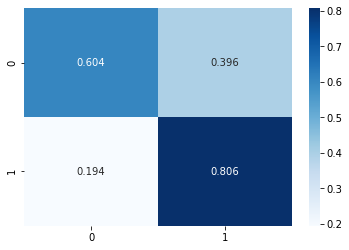

In [16]:
cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

print("Normalized confusion matrix")
print(cm)

labels = [str(round(value, 3)) for row in cm for value in row]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
plt.show()

### Plotting ROC Curve

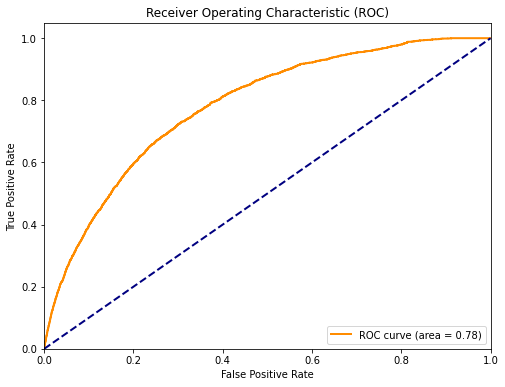

In [19]:
from sklearn.metrics import roc_curve, auc

# Make predictions on the test data and get probability scores
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## Methodology Explanation:

1. Data Preprocessing:
Before training the model, the data has been preprocessed:
- Converted Categorical to Numeric using one-hot encoding.
- Explored the dataset and plotted histograms.
- Feature Scaling: Standardized normalize numerical features.

2. Model Selection:
For fraud detection, I selected tree-based algorithms i.e CatBoost because it performs well due to its ability to handle imbalanced datasets and capture non-linear relationships.

3. Model Evaluation:
Evaluated the model's performance on the test dataset using evaluation metrics like accuracy, precision, recall.
Special attention to metrics like recall, as it is more informative for imbalanced datasets and fraud detection.

Modeling Algorithm: CatBoost

I chose the CatBoost algorithm for fraud detection for several reasons:
- Categorical Feature Handling: CatBoost handles categorical features naturally without the need for one-hot encoding. This is crucial as credit card merchant names and categories are often categorical and can be significant predictors of fraud.
- Robust to Overfitting: CatBoost employs regularization techniques that make it robust to overfitting, which is important in fraud detection where the class imbalance is typically high.
- Gradient Boosting: It is an ensemble method that combines the predictions of multiple decision trees, providing good predictive performance.


## Performance Measure:
Recall (Sensitivity/True Positive Rate):

Recall is the ratio of correctly predicted fraud cases to the total number of actual fraud cases (both true positives and false negatives).  
Recall is crucial when it's essential to identify as many actual fraud cases as possible, even at the cost of some false alarms. It measures the ability of the model to detect fraud effectively.  
False Negatives are more important and should be minimized because flagging a normal transaction would require additional confirmation from user to make a payment but missing to detect a fraud transaction could result in a loss of thousands of dollars.


### Questions and Improvements

- Are there any external datasets that can be incorporated, like merchant risk scores?
- Hyper Parameter Tuning: Utilize techniques like Grid Search to tune hyper parameters  to optimize the model for better performance. 
- Feature Importance Analysis: This can provide insights into which features are most indicative of fraud.   
- Anomaly Detection: For fraud detection, unsupervised anomaly detection techniques (like Isolation Forest or One-Class SVM) could be explored.  
- Deep Learning: With more data, neural networks might be beneficial.  
- Real-time Integration: For effective fraud prevention, the model needs to make predictions in real-time.  
- Feedback Loop: As fraudsters change their tactics, the model should continuously learn from the latest fraud patterns. A feedback loop where investigators confirm or refute the model's predictions can help the model adapt to new patterns.